In [1]:
#add spex templates to selection function
#select the highest SNR spectra of each spectral type i.e 

In [2]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import numba
%matplotlib inline

In [3]:
splat.initializeStandards()

In [22]:
spts=np.array([splat.typeToNum(x) for x in np.arange(20, 40)])

In [23]:
spts

array(['L0.0', 'L1.0', 'L2.0', 'L3.0', 'L4.0', 'L5.0', 'L6.0', 'L7.0',
       'L8.0', 'L9.0', 'T0.0', 'T1.0', 'T2.0', 'T3.0', 'T4.0', 'T5.0',
       'T6.0', 'T7.0', 'T8.0', 'T9.0'], dtype='<U4')

In [24]:
splat_db=splat.searchLibrary(vlm=True, giant=False)

In [25]:
df=splat_db[splat_db.SPEX_TYPE.isin(spts)]

In [34]:
splat_within_snr=df[df.MEDIAN_SNR.between(50, 150)]

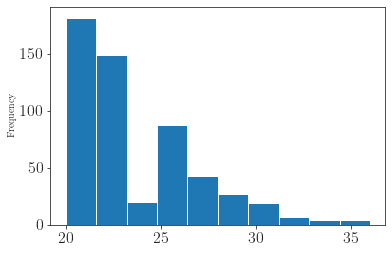

In [37]:
splat_within_snr.SPEX_TYPE.apply(splat.typeToNum).plot(kind='hist', bins=10)

## Group by spt and pick the Top 30

In [44]:
groups=splat_within_snr.sort_values('MEDIAN_SNR',ascending=False).groupby('SPEX_TYPE')

In [50]:
picks=[]
for g in groups:
    picks.append(g[1].nlargest(20,'MEDIAN_SNR'  ))

In [57]:
df_picks=pd.concat(picks)

Text(0.5, 0, 'SNR')

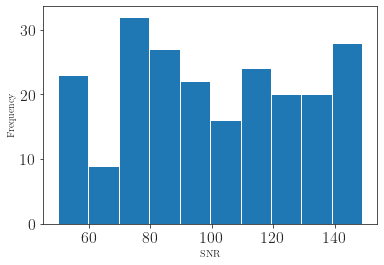

In [58]:
df_picks['MEDIAN_SNR' ].plot(kind='hist')
plt.xlabel('SNR')

In [64]:
import splat

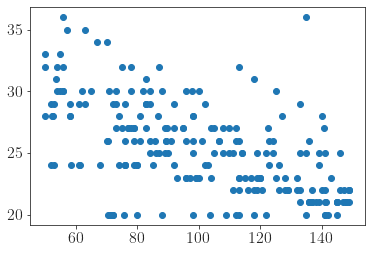

In [66]:
plt.scatter(df_picks.MEDIAN_SNR, df_picks.SPEX_TYPE.apply(splat.typeToNum))

In [82]:

def create_splat_source(filename):
    try:
        #create a wisps spectrum
        #retrieve splat spectrum

        splat_s=splat.getSpectrum(filename=filename)[0]
        spt=splat.typeToNum(splat_s.spex_type)

        #create a source object
        s=wisps.Spectrum( 
                       wave=splat_s.wave.value, 
                       flux=splat_s.flux.value,
                      noise=splat_s.noise.value)

        s.normalize()
        return s
    except OSError:
        return 

In [83]:
%%capture
spectra=df_picks.DATA_FILE.apply(create_splat_source)

In [88]:
xrange

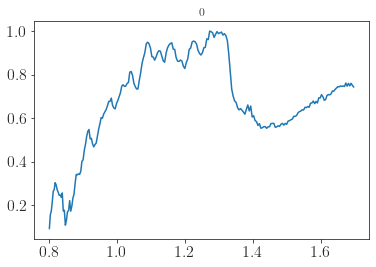

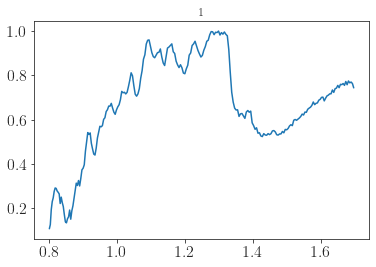

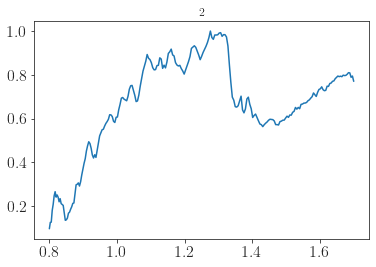

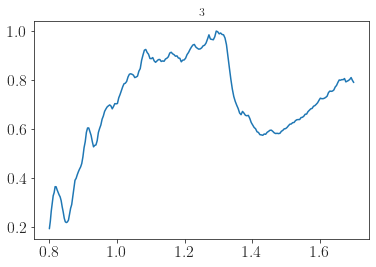

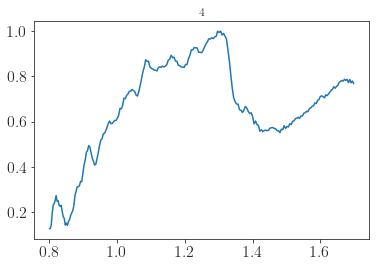

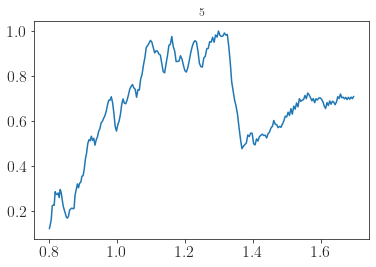

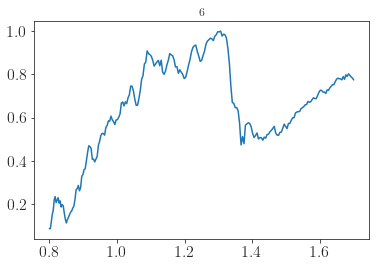

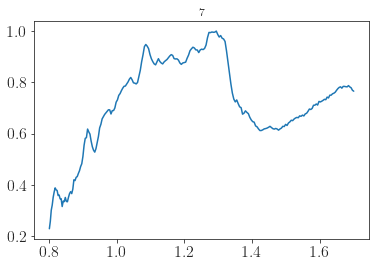

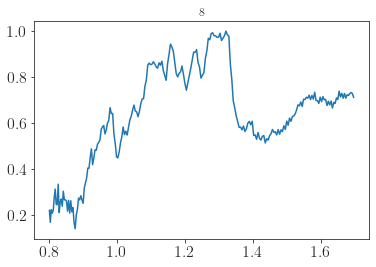

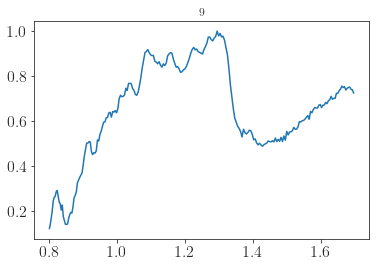

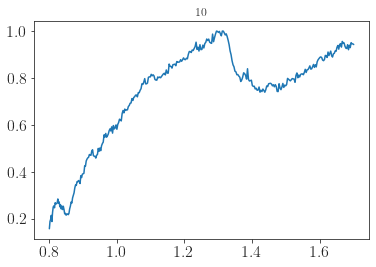

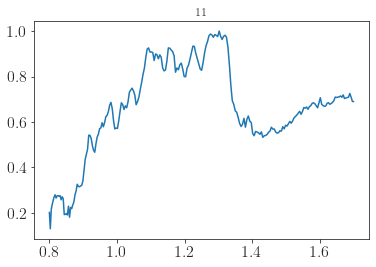

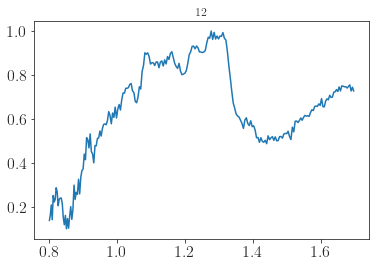

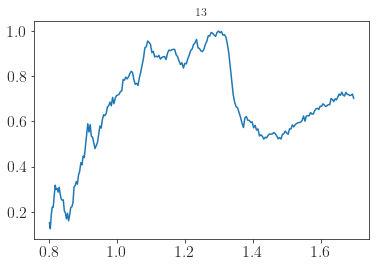

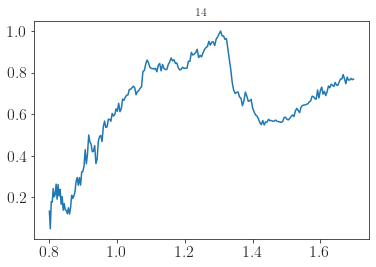

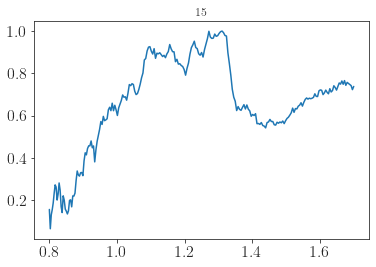

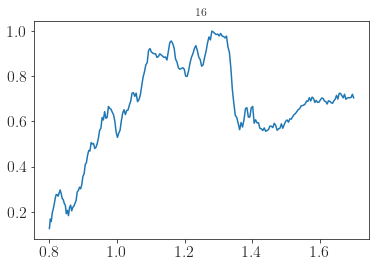

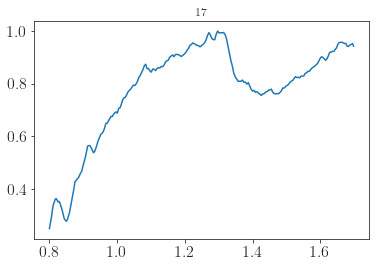

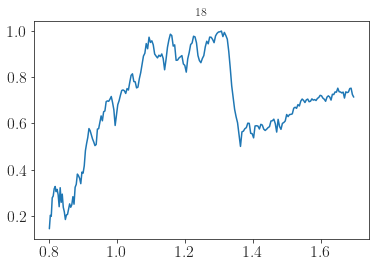

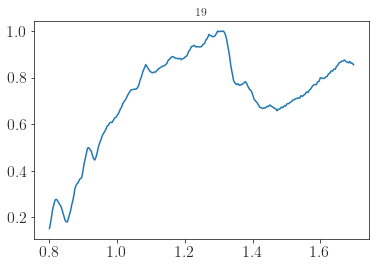

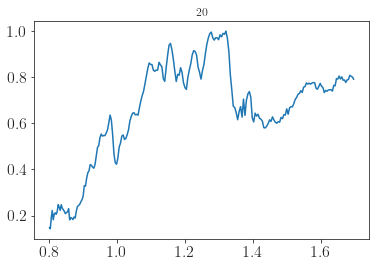

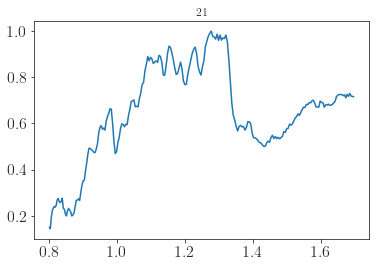

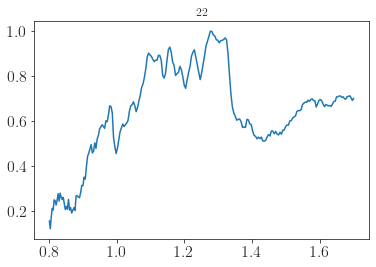

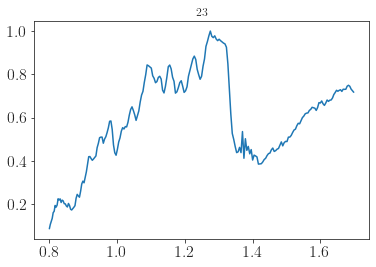

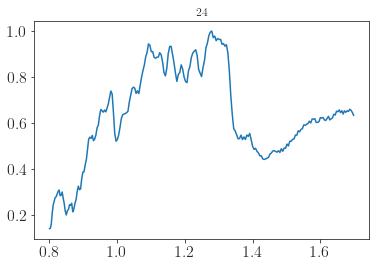

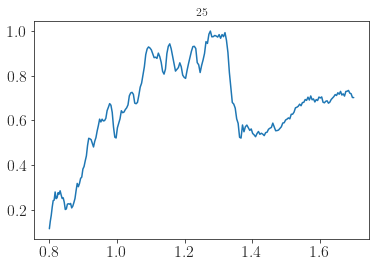

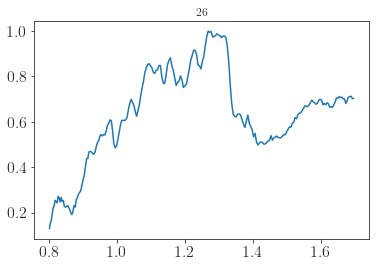

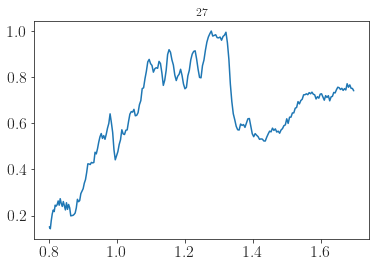

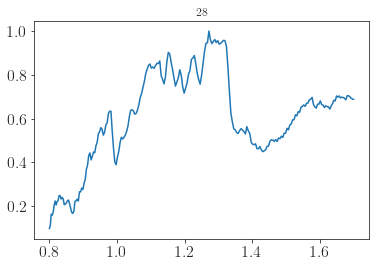

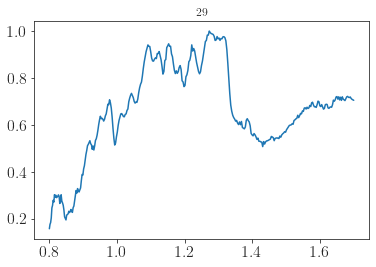

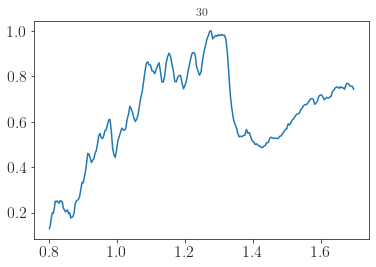

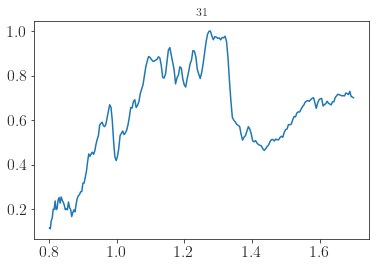

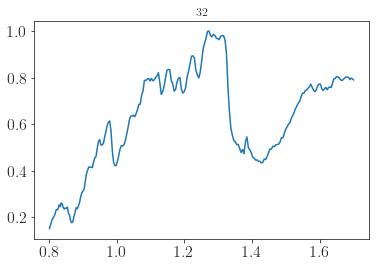

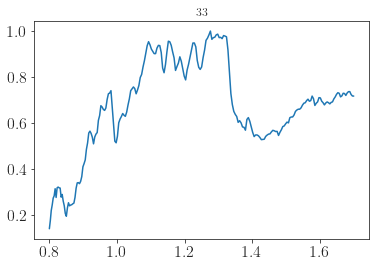

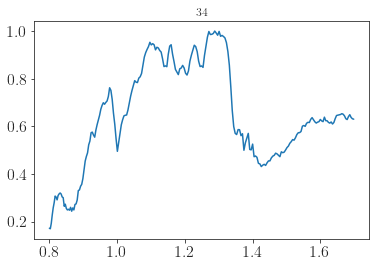

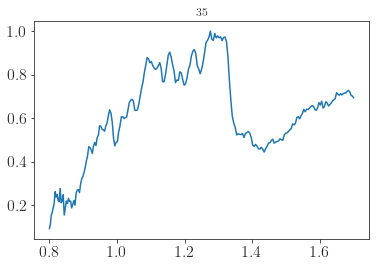

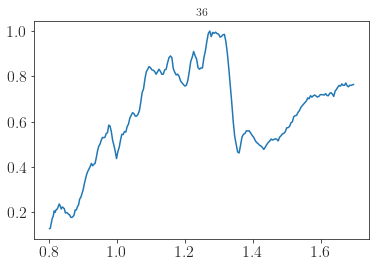

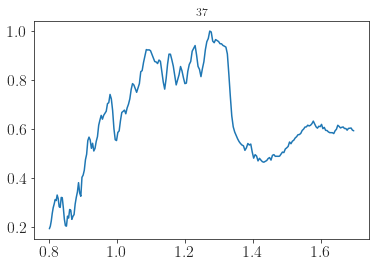

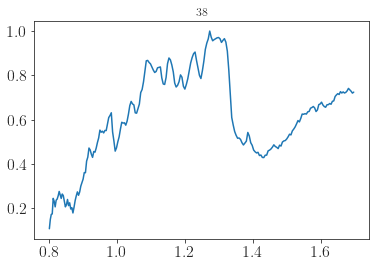

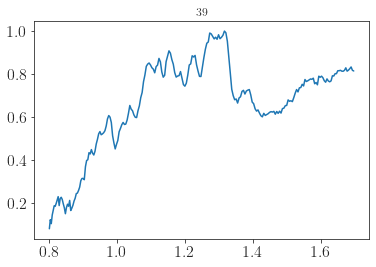

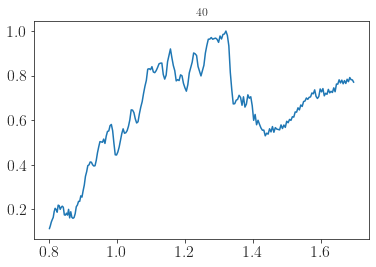

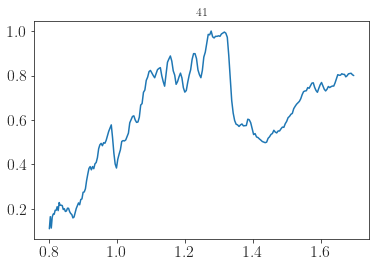

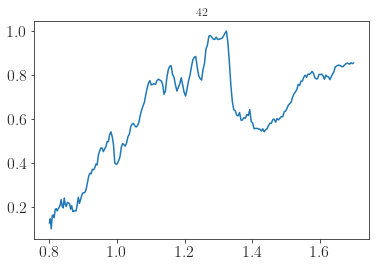

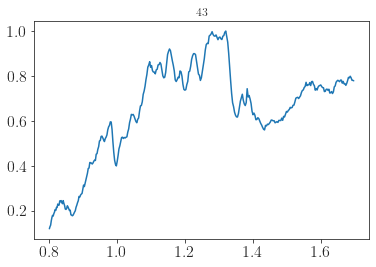

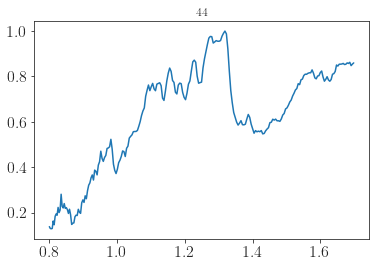

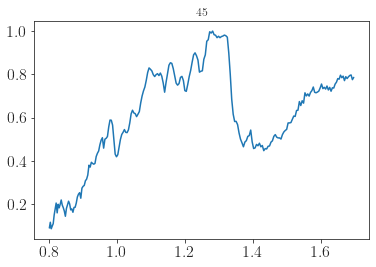

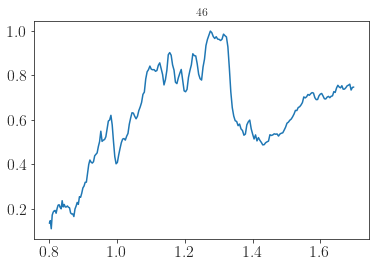

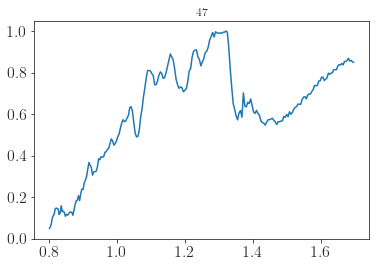

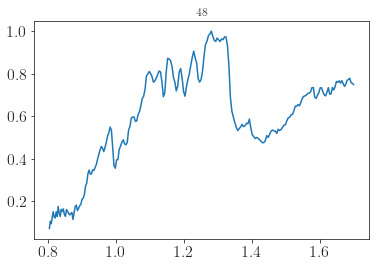

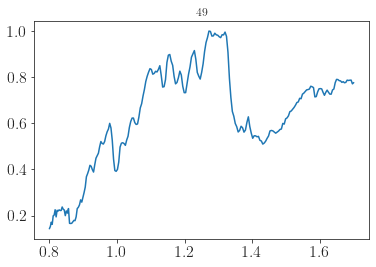

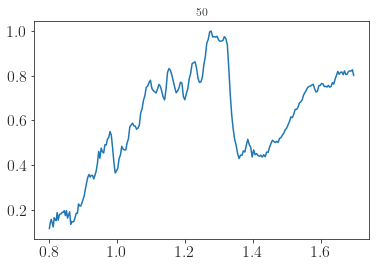

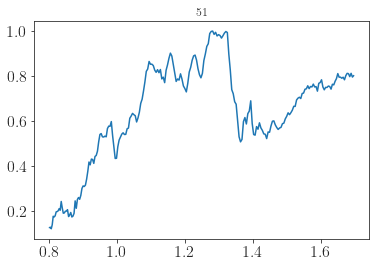

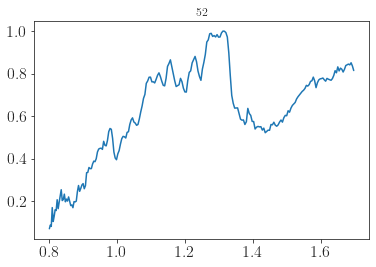

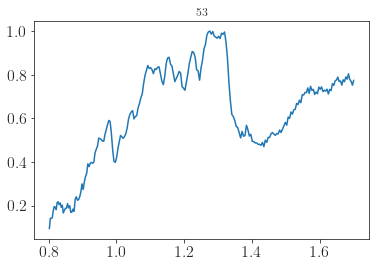

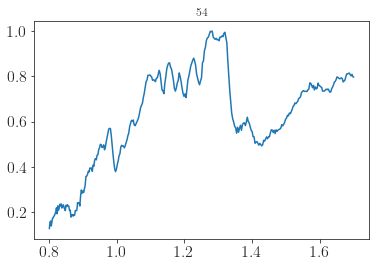

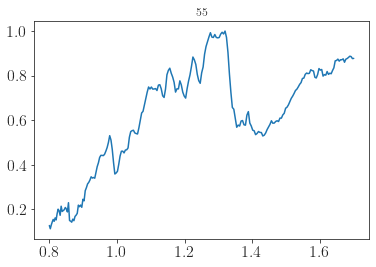

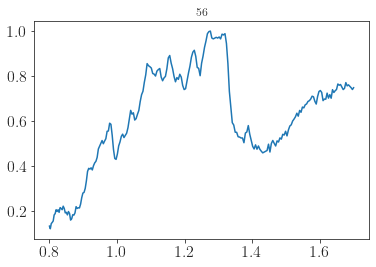

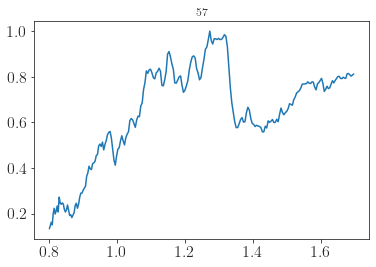

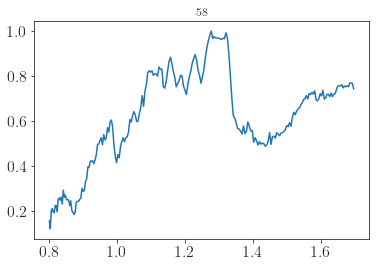

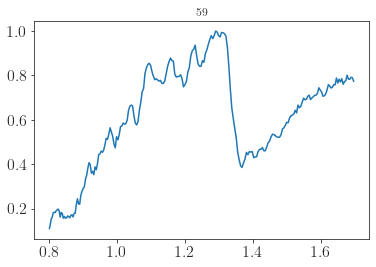

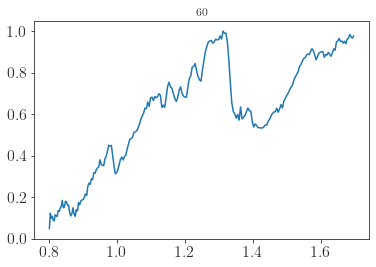

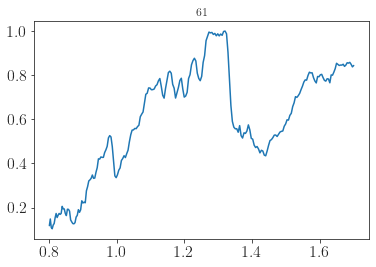

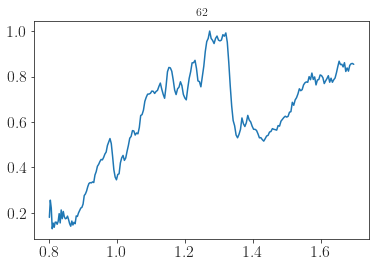

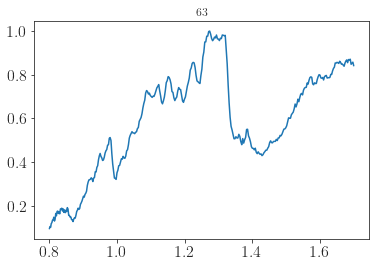

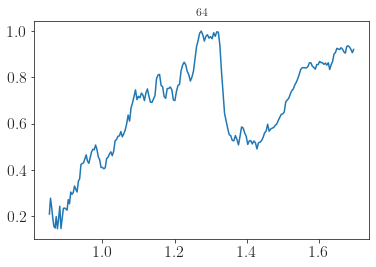

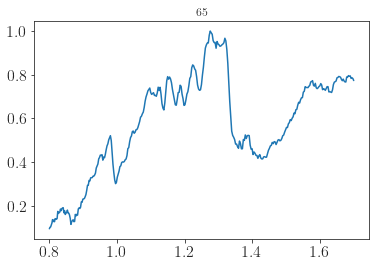

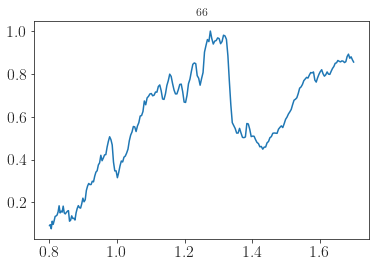

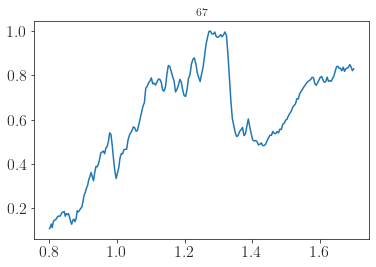

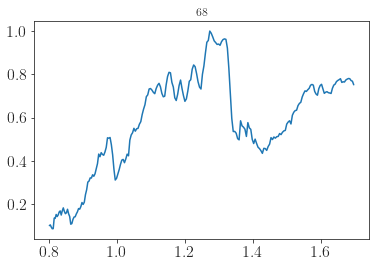

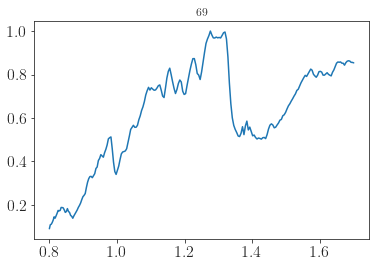

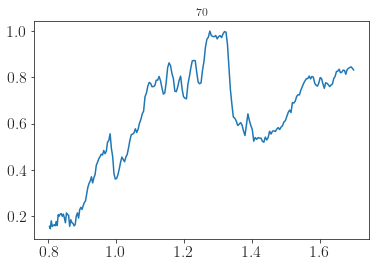

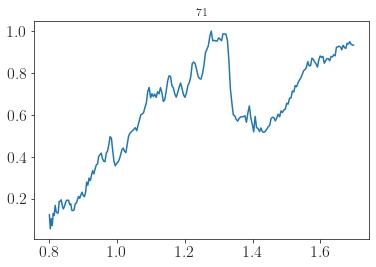

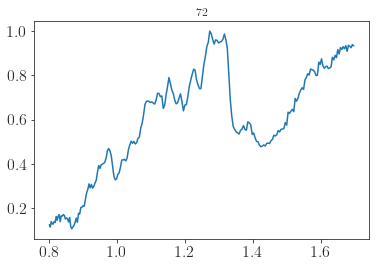

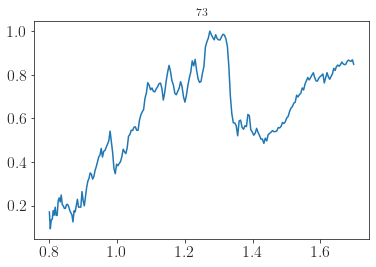

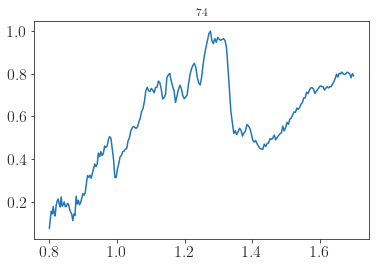

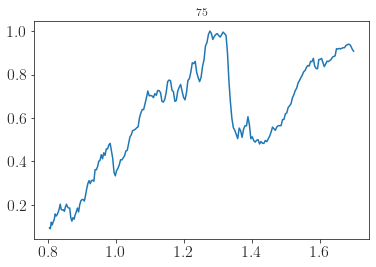

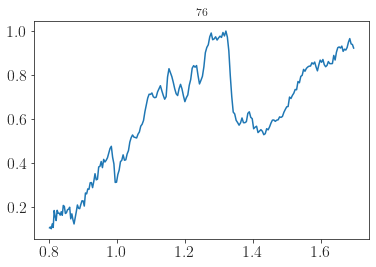

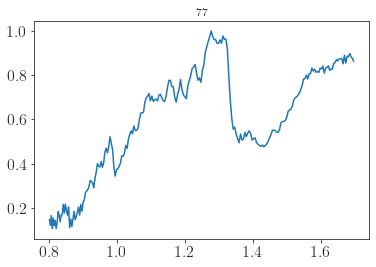

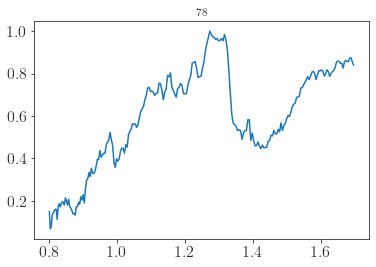

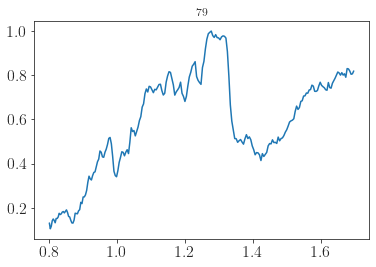

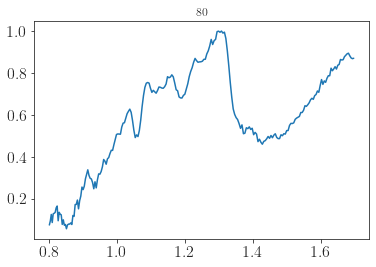

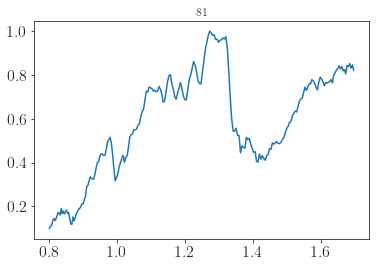

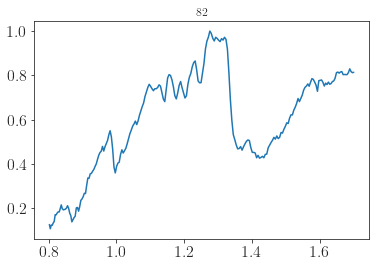

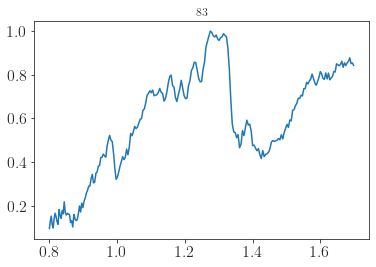

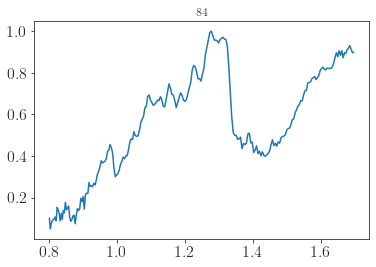

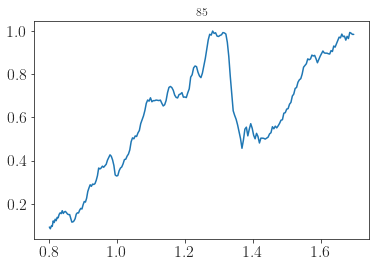

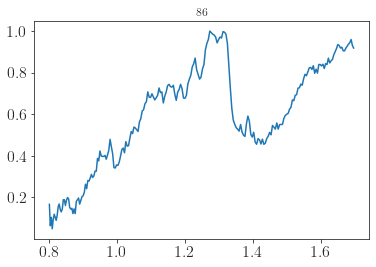

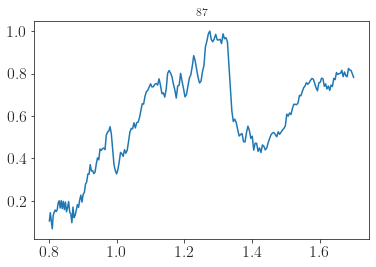

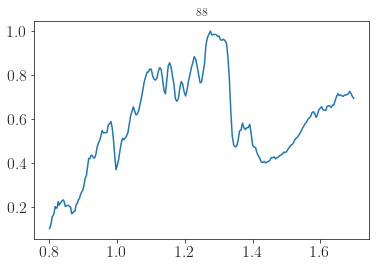

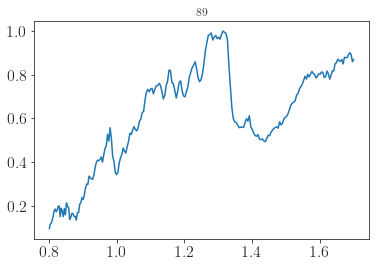

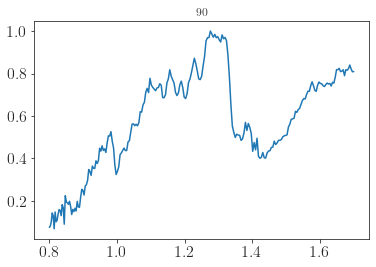

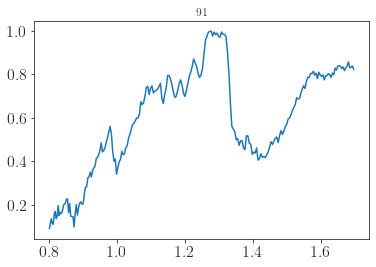

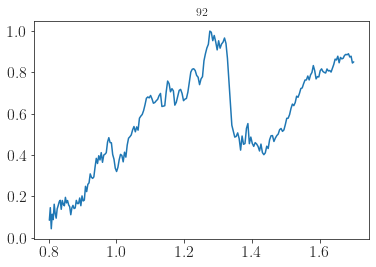

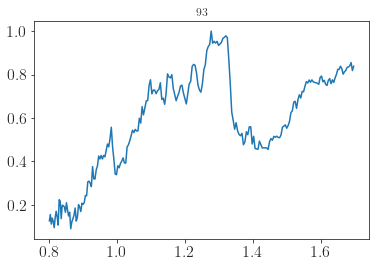

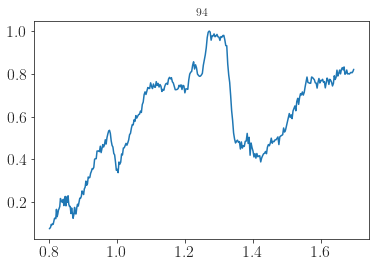

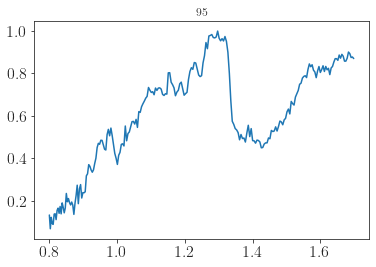

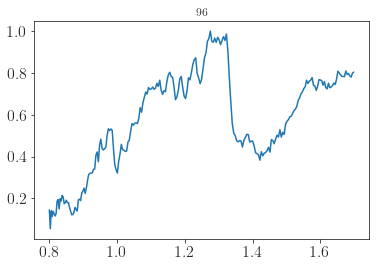

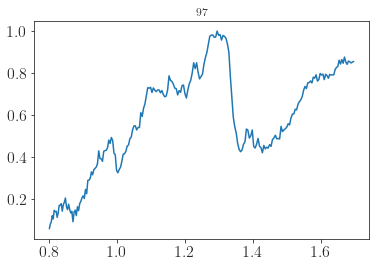

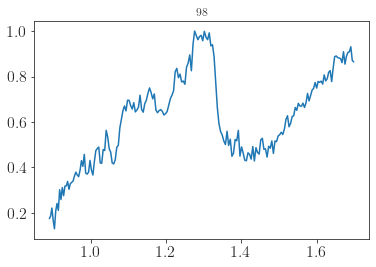

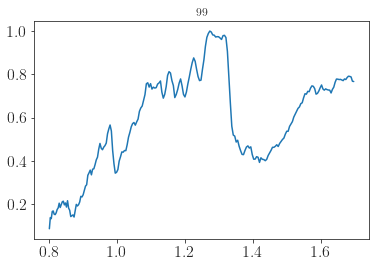

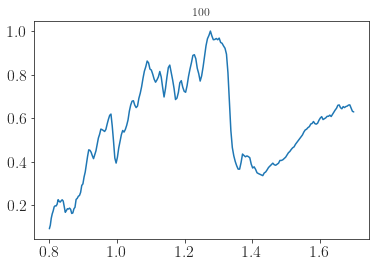

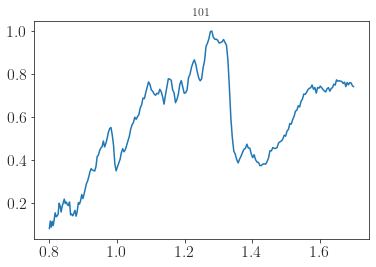

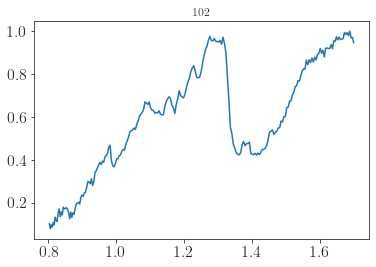

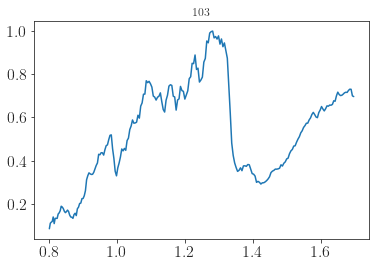

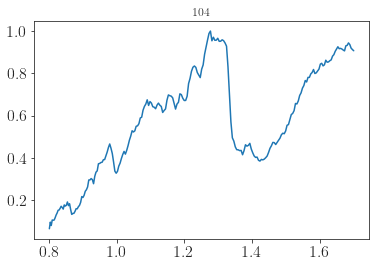

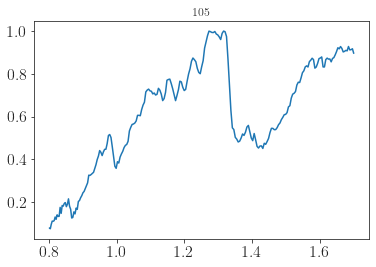

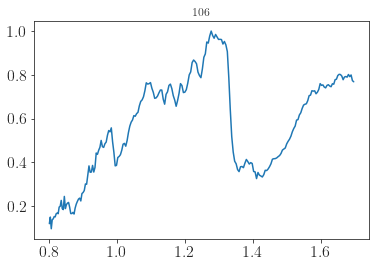

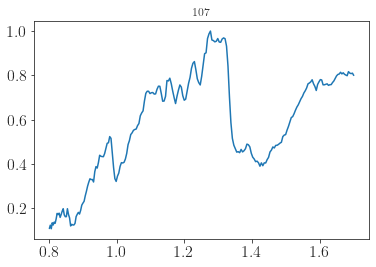

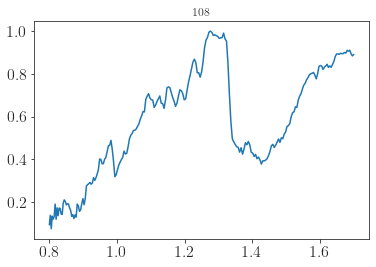

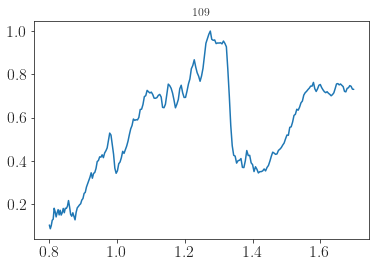

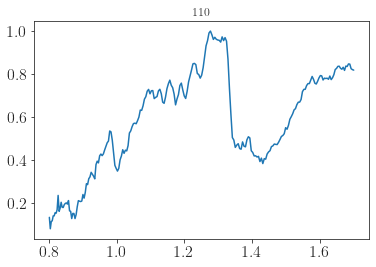

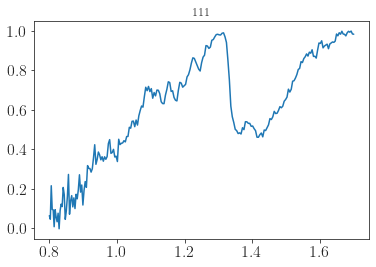

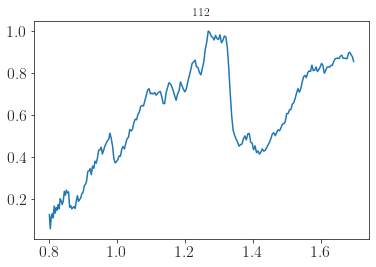

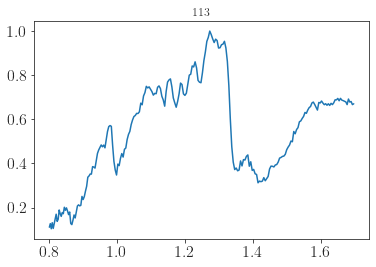

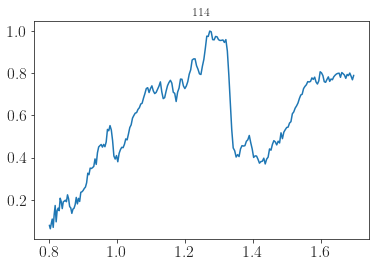

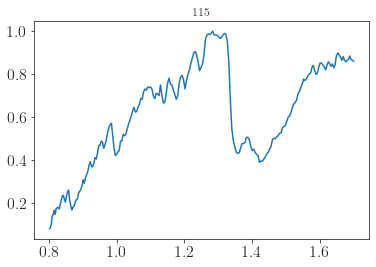

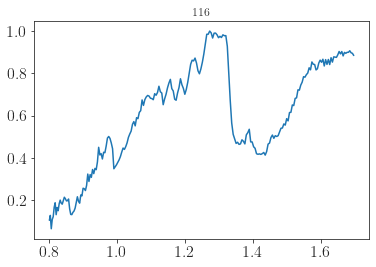

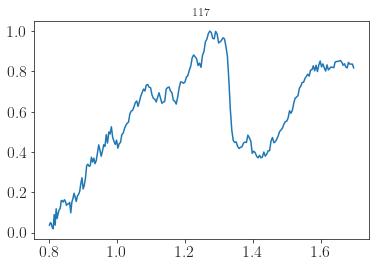

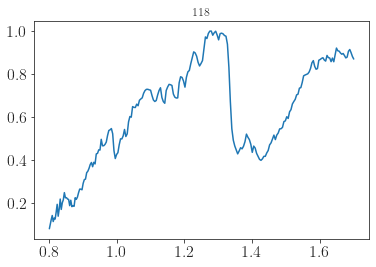

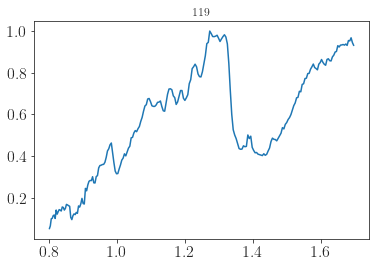

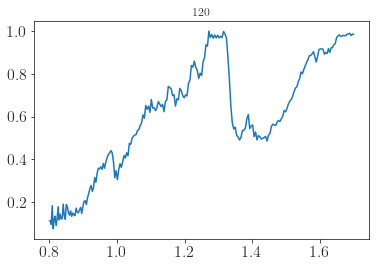

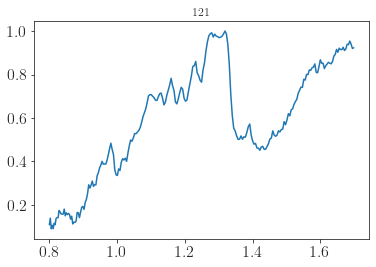

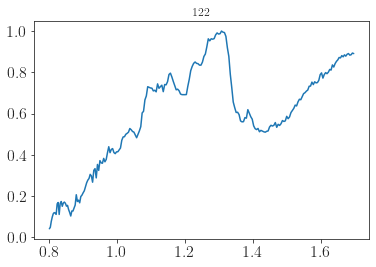

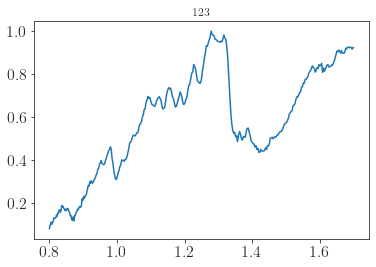

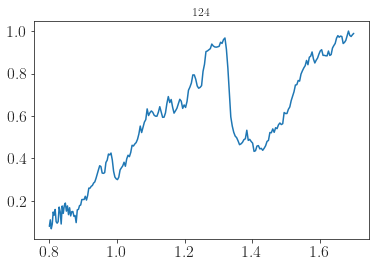

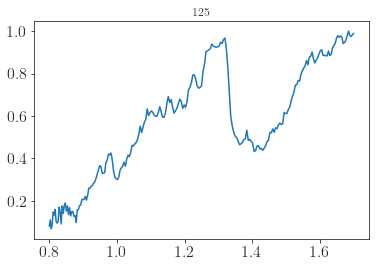

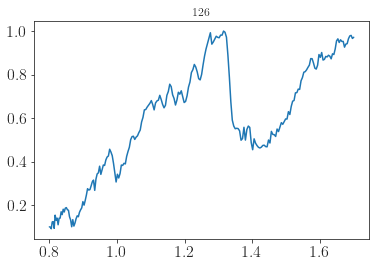

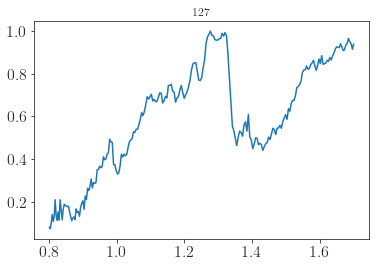

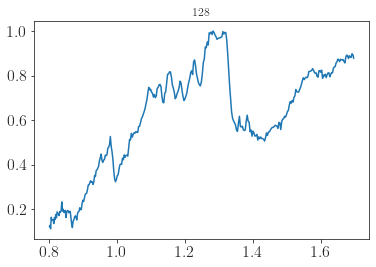

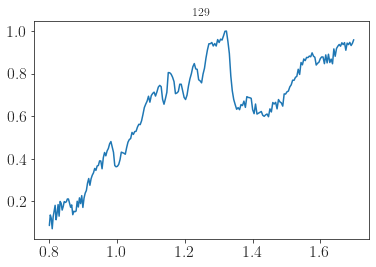

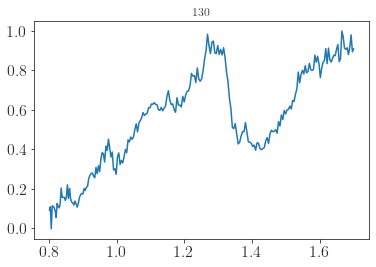

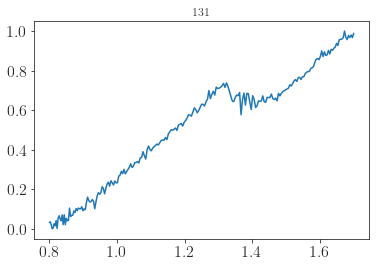

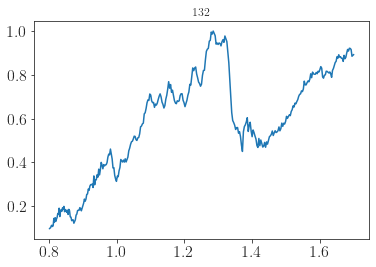

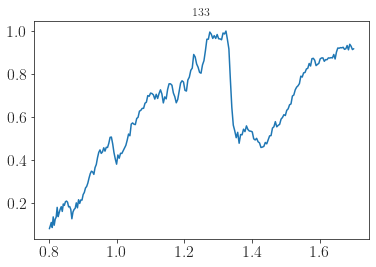

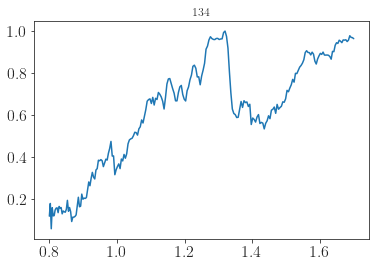

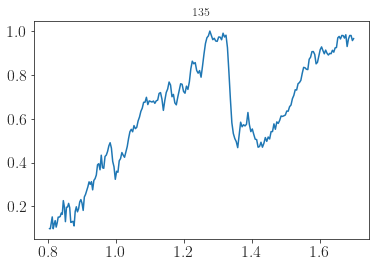

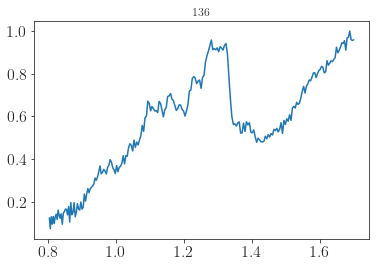

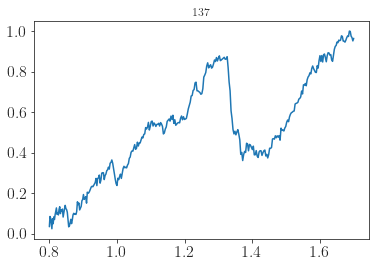

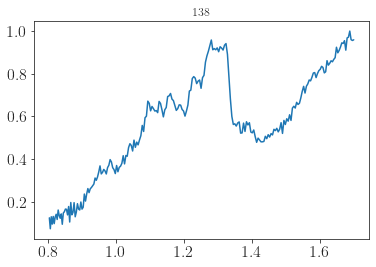

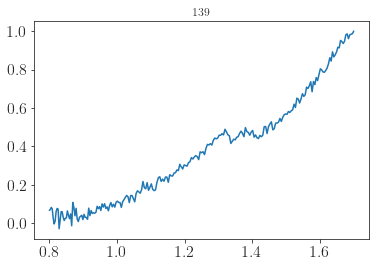

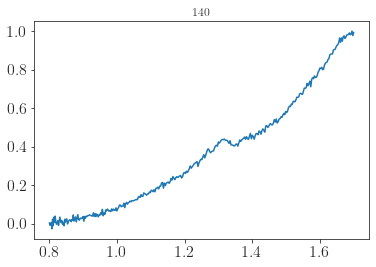

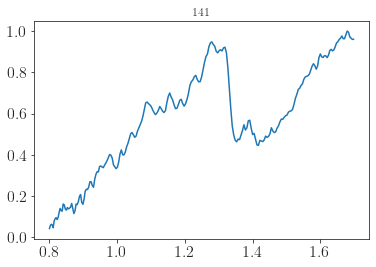

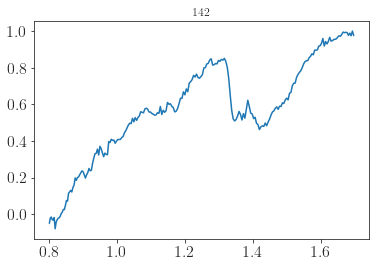

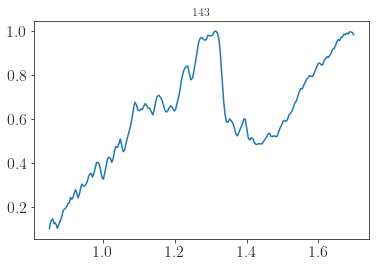

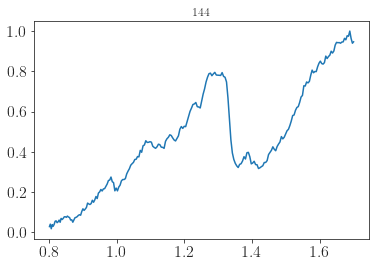

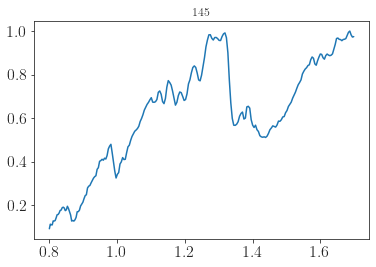

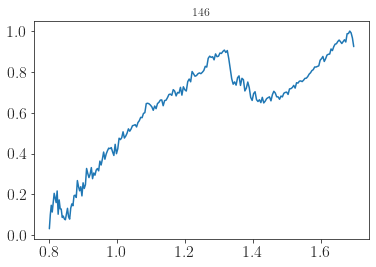

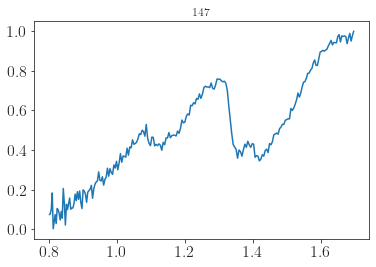

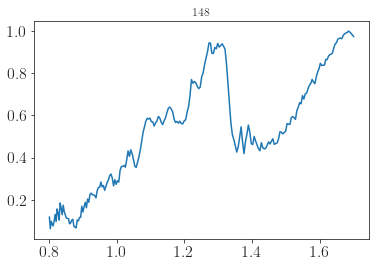

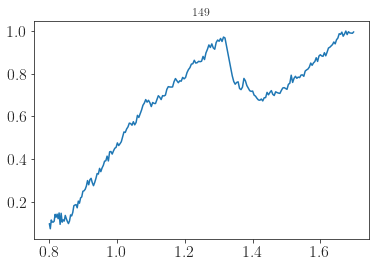

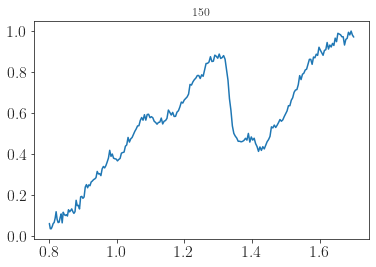

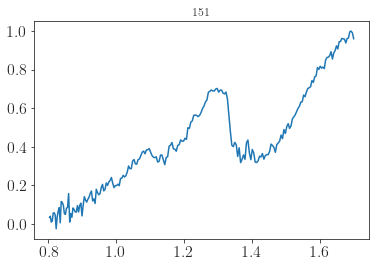

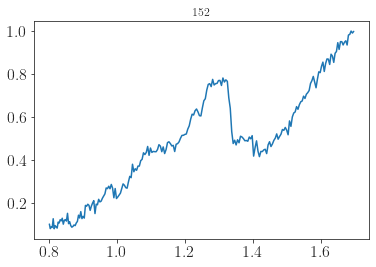

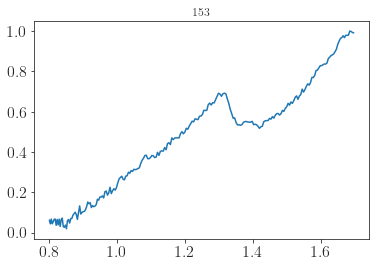

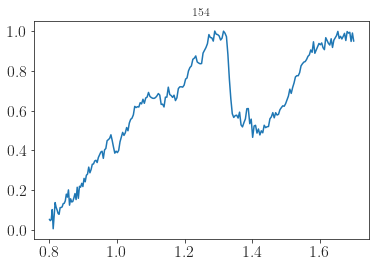

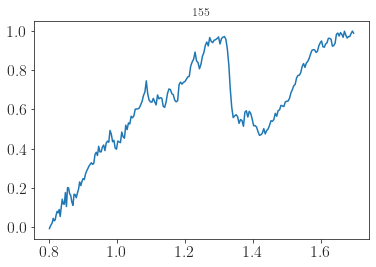

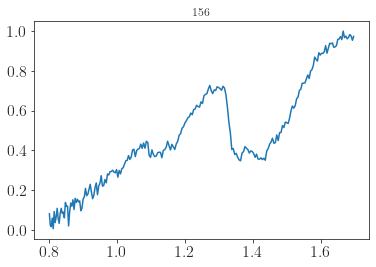

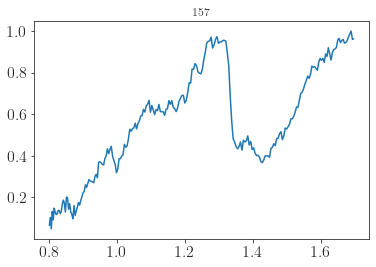

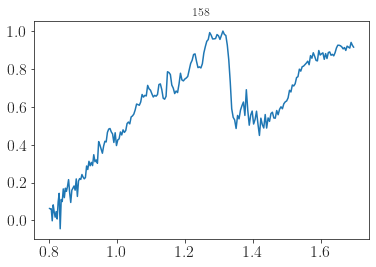

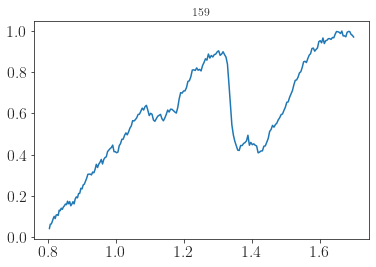

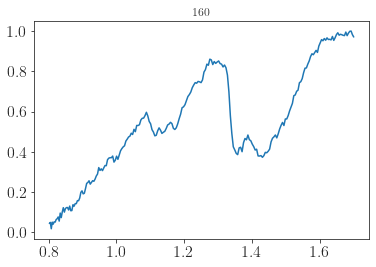

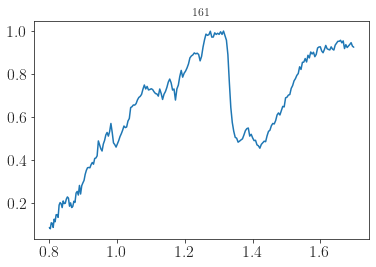

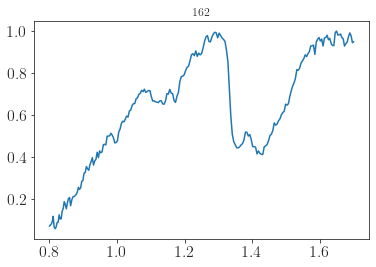

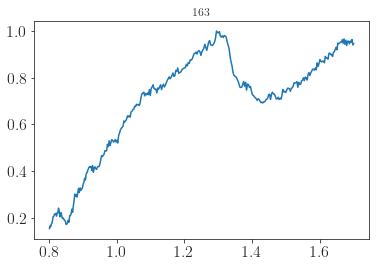

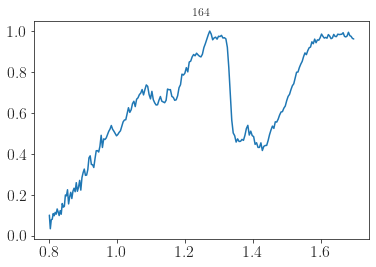

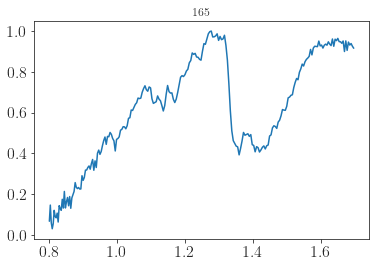

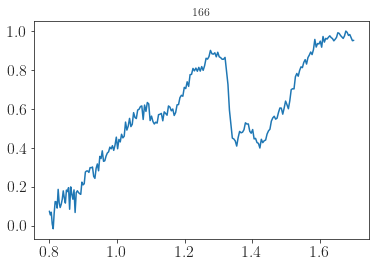

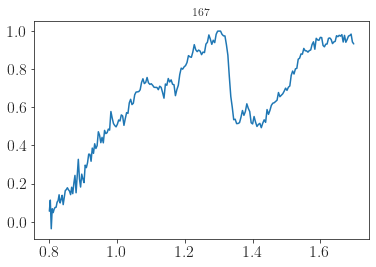

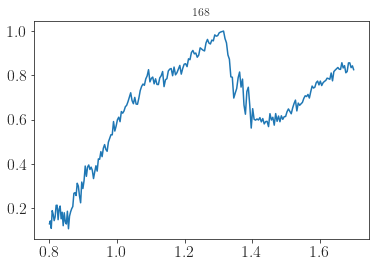

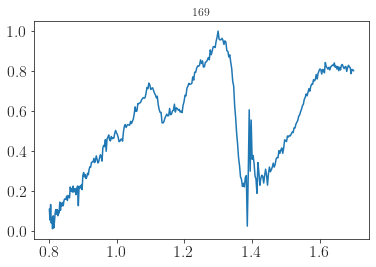

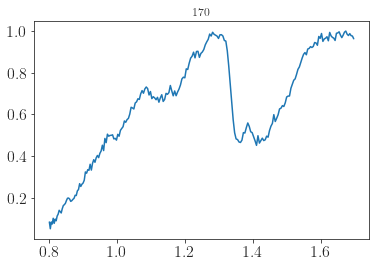

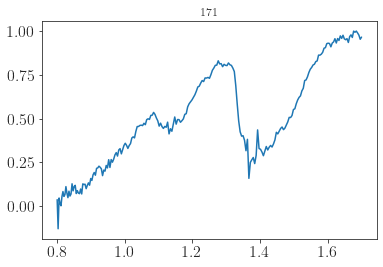

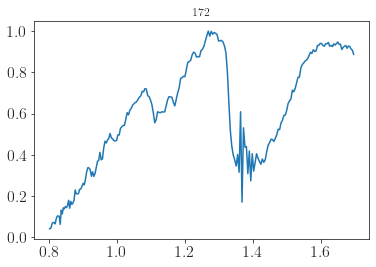

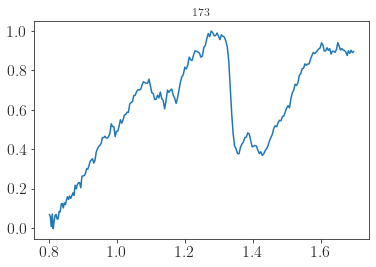

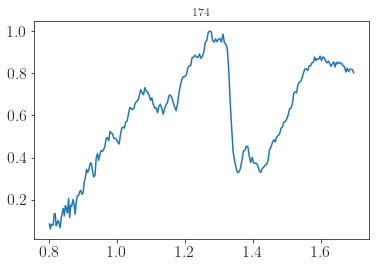

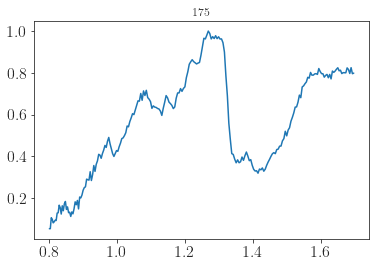

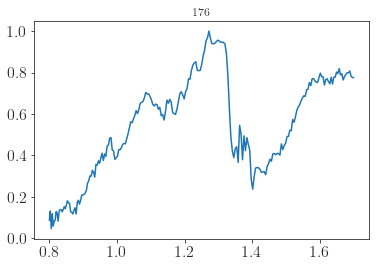

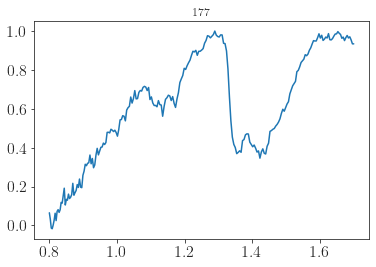

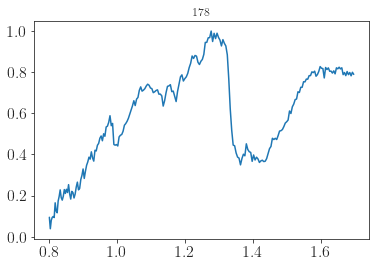

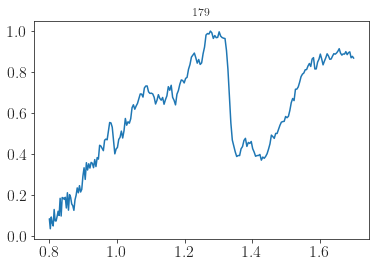

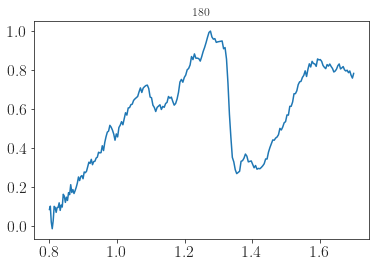

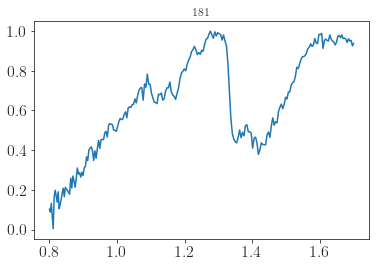

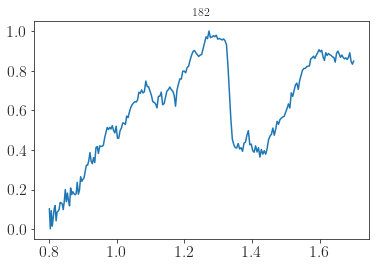

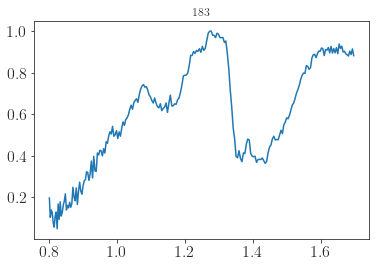

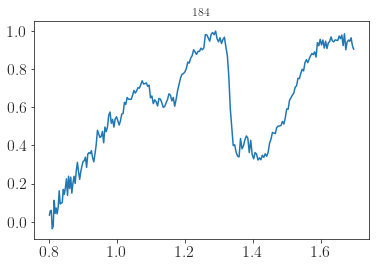

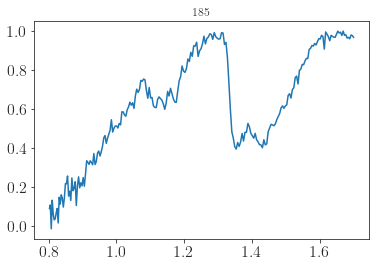

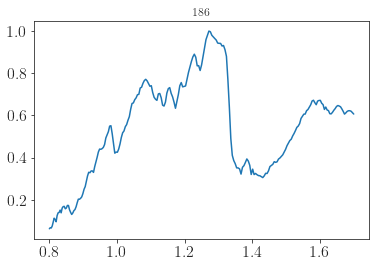

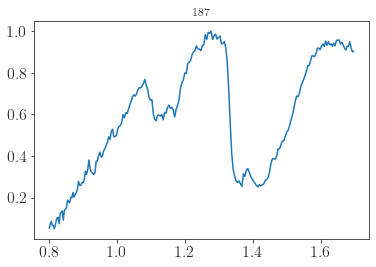

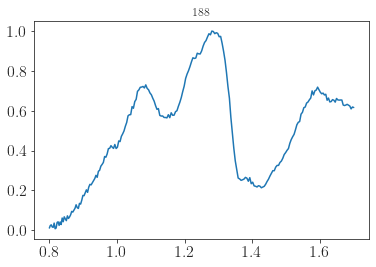

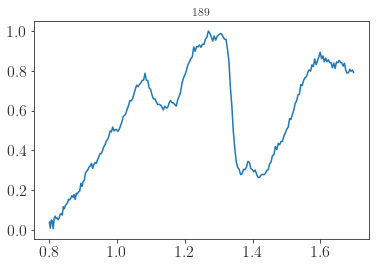

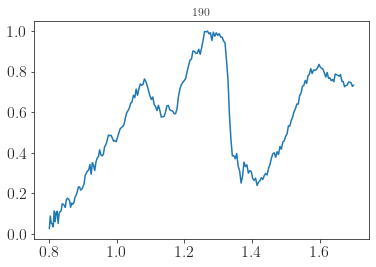

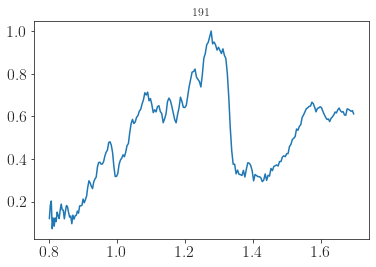

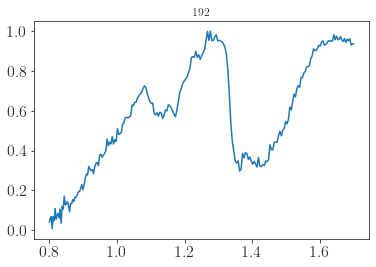

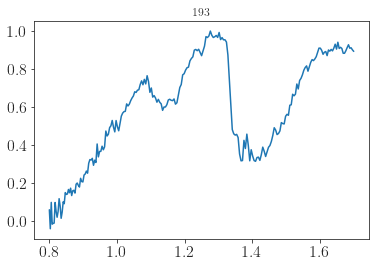

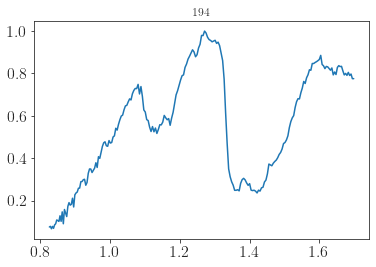

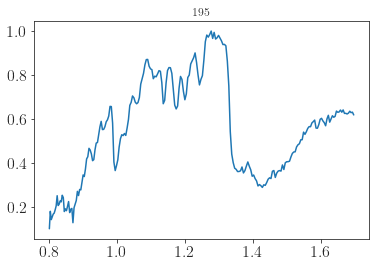

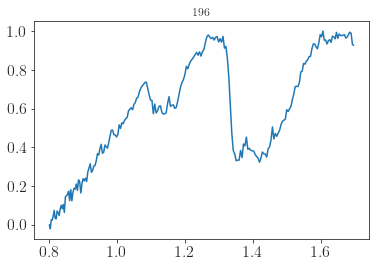

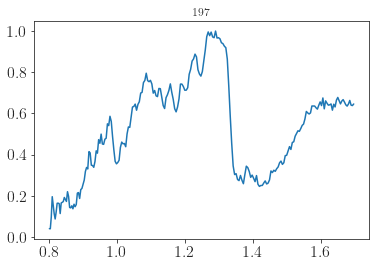

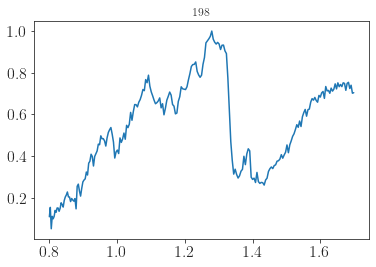

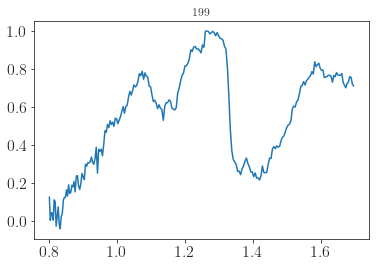

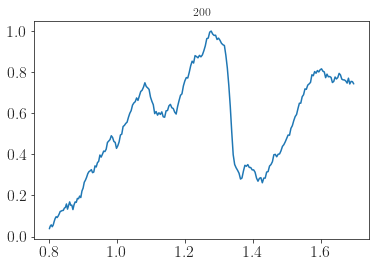

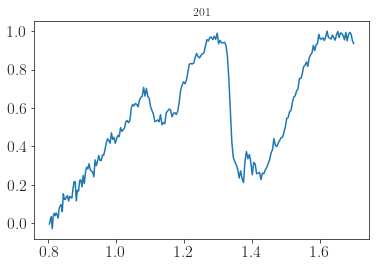

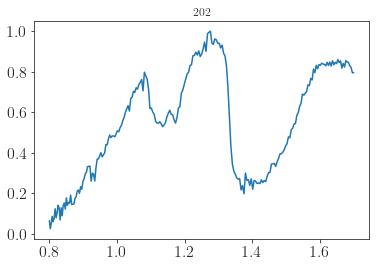

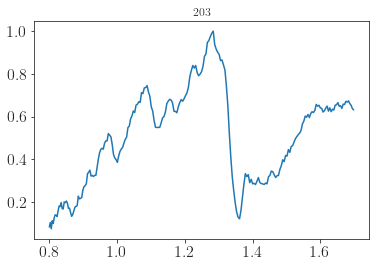

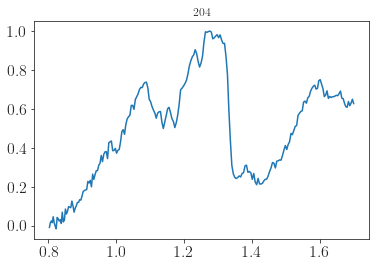

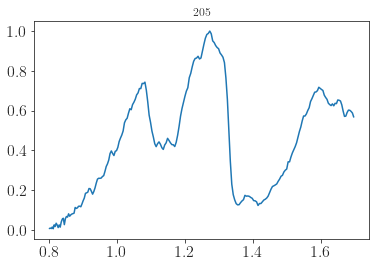

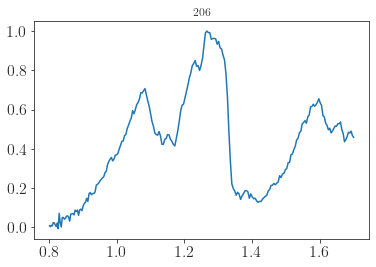

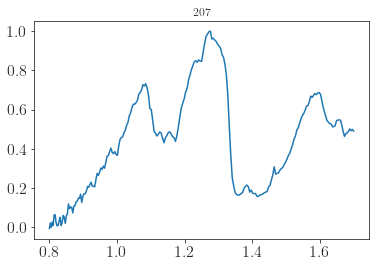

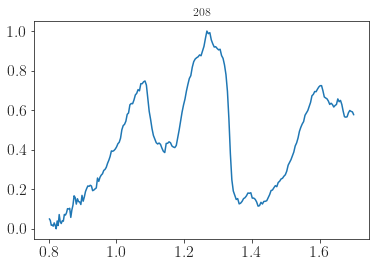

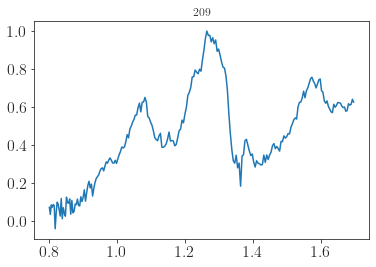

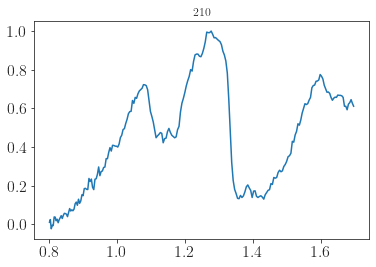

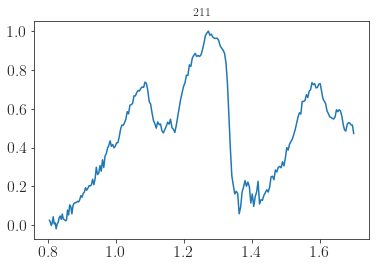

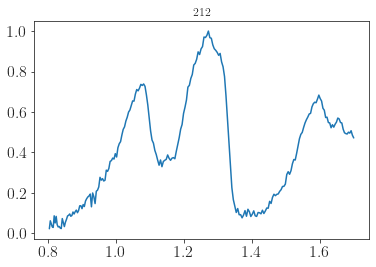

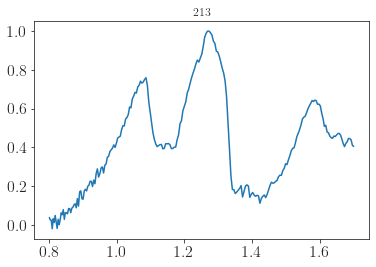

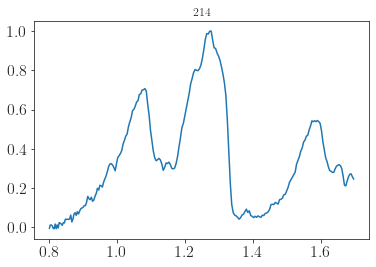

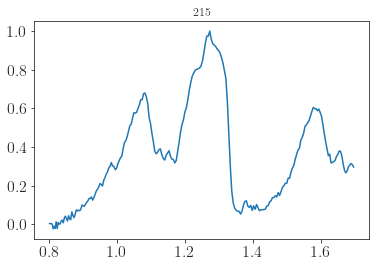

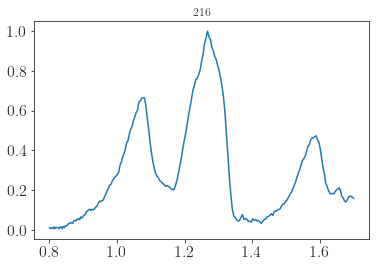

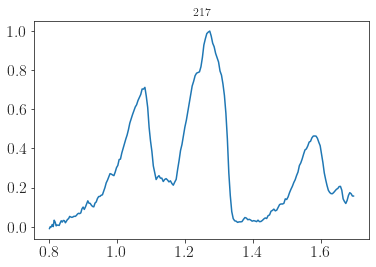

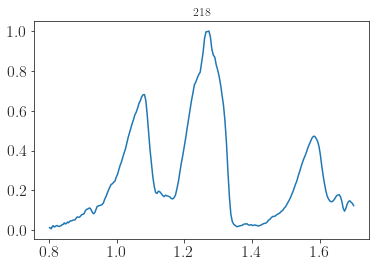

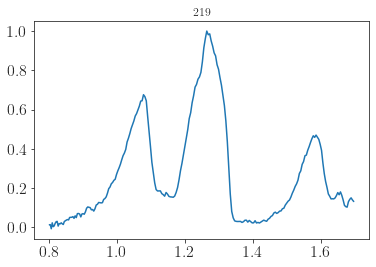

In [115]:
for idx, s in enumerate(spectra.dropna().values):
    mask=np.logical_and(s.wave>0.8, s.wave<1.7)
    plt.plot(s.wave[mask], s.flux[mask])
    plt.title(str(idx))
    plt.show()

In [116]:
remove=[131, 139, 140]

In [124]:
retain=np.delete(spectra.dropna().values, remove)

In [127]:
import pickle
with open(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl', 'wb') as file:
    pickle.dump(retain,file)

In [132]:
#retain[0].snr['snr2']

In [150]:
res=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl')

In [155]:
import wisps.simulations.selection_function as slf

In [254]:
noises=10**np.random.uniform(-1,3,10)

In [250]:

def add_noise_to_spectrum(sp, snr):
    #if I propose a larger SNR don't do anything to save time
    if snr > sp.snr['snr2']:
        f_test={"f_test": sp.f_test, 'line_chi': sp.line_chi, 'spex_chi': sp.spex_chi}
        res_dict= {**sp.snr, **fast_measure_indices(sp), **f_test}
        return res_dict
    else:
        sp.add_noise(snr=snr)
        f_test={"f_test": sp.f_test, 'line_chi': sp.line_chi, 'spex_chi': sp.spex_chi}
        res_dict= {**sp.snr, **fast_measure_indices(sp), **f_test}
        sp.reset()
        return res_dict
    
def add_multiple_noises(sp, noises):
    res=list(map(lambda x: add_noise_to_spectrum(sp, x), noises))
    df=pd.DataFrame.from_records(res)
    df['spt']=sp.spt
    return df

@numba.jit
def fast_measure_indices(sp):
    #fast wway to measure indices without monte-carlo sampling or interpolation
    regions=np.array([[[1.15, 1.20], [1.246, 1.295]],
         [[1.38, 1.43],  [1.15, 1.20]], 
         [[1.56, 1.61],  [1.15, 1.20]], 
         [[1.62,1.67],   [1.15, 1.20]], 
        [[1.38, 1.43],  [1.246, 1.295]], 
         [[1.56, 1.61],  [1.246, 1.295]],
         [[1.62,1.67],   [1.246, 1.295]], 
         [[1.56, 1.61],  [1.38, 1.43]],
         [[1.62,1.67],   [1.38, 1.43]],
         [[1.62,1.67],   [1.56, 1.61]]])
    labels=wisps.INDEX_NAMES
    res=pd.Series()
    res.columns=labels
    #loop over ratios 
    for r, l in zip(regions, labels):
        flx1=np.nanmedian(sp.flux[np.where((sp.wave>r[0][0]) & (sp.wave<r[0][1]))[0]])
        flx2=np.nanmedian(sp.flux[np.where((sp.wave>r[1][0]) & (sp.wave<r[1][1]))[0]])
        res[l]= (flx1/flx2, 0.0)
    return dict(res)
